In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../Mouse brain/MouseBrainLib')
sys.path.append('../Mouse brain network/')
sys.path.append('../Mouse brain network/MouseBrainLib')
import DataUtils as dutl
import random
from collections import deque
import DataUtils as dutl
np.set_printoptions(suppress=True)
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True)
from scipy.optimize import curve_fit

In [4]:
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.transforms as mtransforms

mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import matplotlib as mpl
import matplotlib.font_manager as fm

TEXT_FONT_SIZE = 6
TITLE_FONT_SIZE = 6.5
MARKER_SIZE = 2
LINE_WIDTH = 1

plt.rcParams['font.size'] = TEXT_FONT_SIZE #7 #14
plt.rcParams['axes.linewidth'] = 0.2
plt.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = TEXT_FONT_SIZE #7 #14
mpl.rcParams['axes.titlesize'] = TITLE_FONT_SIZE #7 #14
mpl.rcParams['axes.labelsize'] = TEXT_FONT_SIZE #7 #14
plt.rcParams['axes.facecolor'] = '#F8F8F8'

color_cycle = ['#AA4499', '#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255']

In [5]:
BASE_PATH = '/home/jupyter-avinash/ranjan_env_15_Feb_2023/Explosive Synchronization/Data collection/Mouse brain network/'
data1 = np.load(BASE_PATH + 'Cluster-formation-analysis/mb_data_adaptive_a_0.01_b_0.002_tr_1.npz')
data2 = np.load(BASE_PATH + 'Cluster-formation-analysis/mb_data_adaptive_a_0.01_b_0.002_tr_2.npz')
data3 = np.load(BASE_PATH + 'Cluster-formation-analysis/mb_data_adaptive_a_0.01_b_0.002_tr_3.npz')
data4 = np.load(BASE_PATH + 'Cluster-formation-analysis/mb_data_adaptive_a_0.01_b_0.002_tr_4.npz')

global_order_1 = data1['arr1']
theta_1 = data1['arr3']

global_order_2 = data2['arr1']
theta_2 = data2['arr3']

global_order_3 = data3['arr1']
theta_3 = data3['arr3']

global_order_4 = data4['arr1']
theta_4 = data4['arr3']

print("done")

done


In [6]:
transitoin_time_points_1 = [15700, 31480, 67600, 87900, 
                          117800, 171970, 258150, 299080, 371190]
transitoin_time_points_2 = [14960, 42600, 145340, 156140, 
                          161520, 187930, 194360, 233750, 257930, 327630, 349450, 369440]
transitoin_time_points_3 = [12460, 44330, 82760, 111840, 132780, 152120, 167820, 182210, 
                          190920, 215810, 234820, 271650, 281430, 305700, 326030, 373050, 383400]
transitoin_time_points_4 = [41440, 83660, 112120, 150440, 158350, 228240, 273250, 313840, 
                          333820, 360100, 360100, 368630, 377160, 390990]

# 82760
tr_end_idxes = [9, 21, 38, 52]
subarrays = []
window_size = 1000 #1000

for t in transitoin_time_points_1:
    start_idx = t
    end_idx = start_idx + window_size
    subarrays.append(global_order_1[start_idx:end_idx])
    
for t in transitoin_time_points_2:
    start_idx = t
    end_idx = start_idx + window_size
    subarrays.append(global_order_2[start_idx:end_idx])
    
for t in transitoin_time_points_3:
    start_idx = t
    end_idx = start_idx + window_size
    subarrays.append(global_order_3[start_idx:end_idx])
    
for t in transitoin_time_points_4:
    start_idx = t
    end_idx = start_idx + window_size
    subarrays.append(global_order_4[start_idx:end_idx])

print("done")

done


In [7]:
mb_atlas = dutl.DataUtils()

/home/jupyter-avinash/ranjan_env_15_Feb_2023/Explosive Synchronization/tES_mesoscale_connectivity_model/tES/Mouse brain network/MouseBrainLib/mb_communities.npz already exists
DataUtils initialized


/home/jupyter-avinash/ranjan_env_15_Feb_2023/Explosive Synchronization/tES_mesoscale_connectivity_model/tES/Mouse brain network/../Mouse brain network/MouseBrainLib/DataUtils.py:384: RuntimeWarning: divide by zero encountered in log
  whole_brain_conn = np.log(self.WHOLE_BRAIN_CONN)


(426, 426) (426, 426)


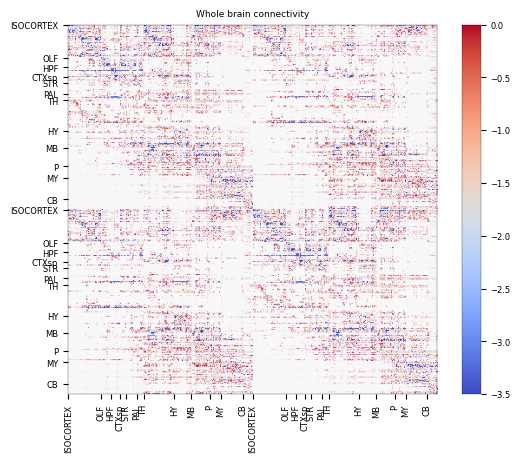

In [8]:
mb_atlas.show_whole_brain_connectivity()

0
2
3
4
6
7
1
5


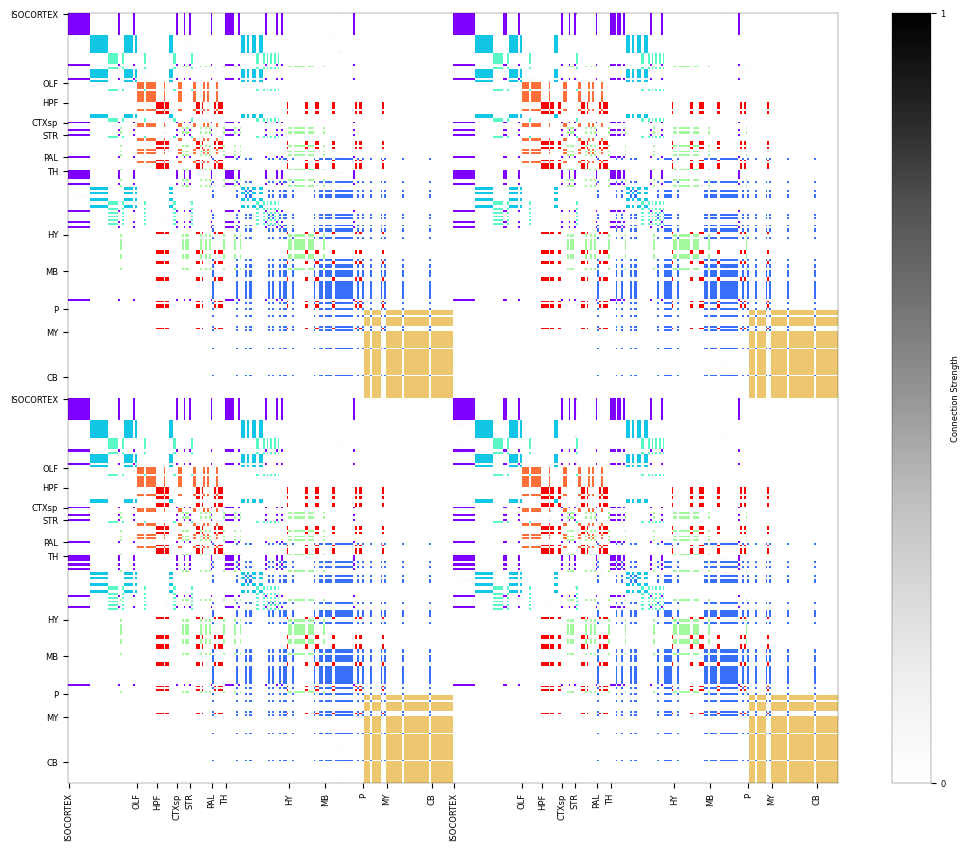

In [9]:
mb_atlas.show_communities()

In [6]:
"""
reordered_community_ids = [3, 0, 2, 6, 4, 7, 1, 5]
["CR1", "MB", "CR2", "CR3", "HYP", "PONS/MD", "OLF/LS", "HPF/LS"]

0: Motor\n/Somatosensory
1: Midbrain
2: Visual/Auditory
3: Orbital
4: Hypothalamus
5: Hindbrain
6: Olfactory
7: Hippocampus
"""
dummy=5

In [10]:
WITHIN_COMM_SYNC_AVG = np.zeros([mb_atlas.N_COMMUNITIES, window_size])
WITHIN_COMM_SYNC_VERBOSE = np.zeros([len(subarrays), mb_atlas.N_COMMUNITIES, window_size])
WITHIN_COMM_SYNC_VAR = np.zeros([mb_atlas.N_COMMUNITIES, window_size])
WITHIN_COMM_SYNC_CUMLTV = np.zeros([len(subarrays), mb_atlas.N_COMMUNITIES, window_size])

"""
BUG Alert!

this is a minor bug but might be present at other places at well.

>= instead of >
"""

# Does not take binary weight into account
for i in range(len(subarrays)): #len(subarrays)
    temp_mean = np.zeros([mb_atlas.N_COMMUNITIES, window_size])
    
    for community_id, nodes in mb_atlas.COMMUNITIES.items():
        for idx in range(0, window_size):
            if i < tr_end_idxes[0]: 
                temp_mean[community_id, idx] = np.abs( 
                    np.mean(np.exp(1j*theta_1[idx + transitoin_time_points_1[i], nodes])) )
                    # np.median(np.exp(1j*theta_1[idx + transitoin_time_points_1[i], nodes])) )
            elif i >= tr_end_idxes[0] and i < tr_end_idxes[1]:
                temp_mean[community_id, idx] = np.abs( 
                    np.mean(np.exp(1j*theta_2[idx + transitoin_time_points_2[i - tr_end_idxes[0]], nodes])) )
                    # np.median(np.exp(1j*theta_2[idx + transitoin_time_points_2[i - tr_end_idxes[0]], nodes])) )
                    
            elif i >= tr_end_idxes[1] and i < tr_end_idxes[2]:
                temp_mean[community_id, idx] = np.abs( 
                    np.mean(np.exp(1j*theta_3[idx + transitoin_time_points_3[i - tr_end_idxes[1]], nodes])) )
                    # np.median(np.exp(1j*theta_3[idx + transitoin_time_points_3[i - tr_end_idxes[1]], nodes])) )
            elif i >= tr_end_idxes[2] and i < tr_end_idxes[3]:
                temp_mean[community_id, idx] = np.abs( 
                    np.mean(np.exp(1j*theta_4[idx + transitoin_time_points_4[i - tr_end_idxes[2]], nodes])) )
                    # np.median(np.exp(1j*theta_4[idx + transitoin_time_points_4[i - tr_end_idxes[2]], nodes])) )
            
            WITHIN_COMM_SYNC_CUMLTV[i, community_id, idx] = temp_mean[community_id, idx]
            WITHIN_COMM_SYNC_VERBOSE[i, community_id, idx] = temp_mean[community_id, idx]
            
    WITHIN_COMM_SYNC_AVG = WITHIN_COMM_SYNC_AVG + temp_mean

WITHIN_COMM_SYNC_AVG = WITHIN_COMM_SYNC_AVG/len(subarrays)
WITHIN_COMM_SYNC_VAR = np.var(WITHIN_COMM_SYNC_CUMLTV, axis=0)
print("done")

done


In [11]:
BETWEEN_COMM_SYNC_AVG = np.zeros([mb_atlas.N_COMMUNITIES, mb_atlas.N_COMMUNITIES, window_size])

"""
Synchrony level is calculated for all pair of nodes.
"""

# Do it for each community pair
for i in range(len(transitoin_time_points_1)): # Do it for all 52 transients
    temp = np.zeros([mb_atlas.N_COMMUNITIES, mb_atlas.N_COMMUNITIES, window_size])
    for community_id_i, nodes_i in mb_atlas.COMMUNITIES.items():
        for community_id_j, nodes_j in mb_atlas.COMMUNITIES.items():
            # if community_id_i == community_id_j:
            #     continue

            for idx in range(window_size):
                a = np.exp(1j*theta_1[idx + transitoin_time_points_1[i], nodes_i])
                b = np.exp(1j*theta_1[idx + transitoin_time_points_1[i], nodes_j]).T
                avg_sum = (a + b)/2

                temp[community_id_i, community_id_j, idx] = np.abs(np.mean(avg_sum))
    BETWEEN_COMM_SYNC_AVG = BETWEEN_COMM_SYNC_AVG + temp

BETWEEN_COMM_SYNC_AVG = BETWEEN_COMM_SYNC_AVG/len(subarrays)

print("done")

done


**TODO: Save it as a video**

In [12]:
reordered_community_ids = [3, 0, 2, 6, 4, 7, 1, 5]

community_labels = ["Orbital", 
                    "Motor\n/Somatosensory", 
                    "Visual/Auditory", 
                    "Olfactory", 
                    "Hypothalamus", 
                    "Hippocampus", 
                    "Midbrain", 
                    "Hindbrain"]

colors =  ["blue", "darkgreen", "skyblue", "cyan", "olive", "brown", "#007FFF", "green"]
community_cmap = mcolors.ListedColormap(colors)

node_order = []
for community in reordered_community_ids:
    node_order.extend(mb_atlas.COMMUNITIES[community])
print("done")

done


In [13]:
def show_tracking_color_bar(ax, pos=0):
    # color_ranges = [(0, 0.5), (0.5, 1.5), (1.5, 2.5), (2.5, 3.5), (3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7)] 
    color_ranges = [(0, 0.5), 
                    (0.5, 1), (1, 1.5), 
                    (1.5, 2), (2, 2.5), 
                    (2.5, 3), (3, 3.5), 
                    (3.5, 4), (4, 4.5), 
                    (4.5, 5), (5, 5.5), 
                    (5.5, 6), (6, 6.5), 
                    (6.5, 7)] 
    
    dummy_reordered_community_ids = [3, 0, 0, 2, 2, 6, 6, 4, 4, 7, 7, 1, 1, 5]
    
    # Create a ScalarMappable object using a colormap and normalize the x-values
    cmap = mcolors.ListedColormap(community_cmap(np.array(dummy_reordered_community_ids)/8))
    
    bounds = [r[0] for r in color_ranges] + [color_ranges[-1][1]]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Create a color bar using the ScalarMappable
    tracking_cbar = plt.colorbar(sm, orientation='horizontal',
                                 pad=-0.27, ax=ax, alpha=0.6, aspect=23) #0.047
    tracking_cbar.set_ticks([])
    tracking_cbar.set_ticklabels([])
    # Hide tick markers
    tracking_cbar.ax.xaxis.set_ticks_position('none')
    tracking_cbar.ax.yaxis.set_ticks_position('none')
    # tracking_cbar.set_label("Communities", fontsize=12)
    
    if pos == 0:
        draw_brace_horizontal(ax, (0, 3.5), 'CRTX\n-TH', 0)
        draw_brace_horizontal(ax, (3.5, 6.5), 'SUB-\nCRTX', 1)
        draw_brace_horizontal(ax, (6.5, 7), 'HB', 2)
    

def show_tracking_color_bar2(ax, pos=0):
    color_ranges = [(0, 0.5), 
                    (0.5, 1), (1, 1.5), 
                    (1.5, 2), (2, 2.5), 
                    (2.5, 3), (3, 3.5), 
                    (3.5, 4), (4, 4.5), 
                    (4.5, 5), (5, 5.5), 
                    (5.5, 6), (6, 6.5), 
                    (6.5, 7)] 
    
    dummy_reordered_community_ids = [3, 0, 0, 2, 2, 6, 6, 4, 4, 7, 7, 1, 1, 5]
    
    # Create a ScalarMappable object using a colormap and normalize the x-values
    cmap = mcolors.ListedColormap(community_cmap(np.array(dummy_reordered_community_ids)/8))
    
    # Create a ScalarMappable object using a colormap and normalize the x-values
    cmap = mcolors.ListedColormap(community_cmap(np.array(dummy_reordered_community_ids)/8))
    bounds = [r[0] for r in color_ranges] + [color_ranges[-1][1]]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a color bar using the ScalarMappable
    tracking_cbar = plt.colorbar(sm, 
                                 location='left',
                                 pad=-0.42, ax=ax, alpha=0.6)
    tracking_cbar.set_ticks([])
    tracking_cbar.set_ticklabels([])
    # Hide tick markers
    tracking_cbar.ax.xaxis.set_ticks_position('none')
    tracking_cbar.ax.yaxis.set_ticks_position('none')
    # tracking_cbar.set_label("Communities", fontsize=12)
    
    ax.spines['left'].set_position(('outward', 0))
    
    # draw_brace(tracking_cbar.ax, (0, 3), 'crtx-th')
    # draw_brace(tracking_cbar.ax, (3, 6), 'subcrtx')
    # draw_brace(tracking_cbar.ax, (6, 7), 'HB')
    
    draw_brace(ax, (0, 3.5), 'CRTX\n-TH', 0)
    draw_brace(ax, (3.5, 6.5), 'SUB-\nCRTX', 1)
    draw_brace(ax, (6.5, 7), 'HB', 2)
    

def draw_brace(ax, yspan, text, pos):
    """Draws an annotated brace on the axes."""
    ymin, ymax = yspan
    yspan = ymax - ymin
    ax_ymin, ax_ymax = ax.get_ylim()
    yax_span = ax_ymax - ax_ymin
    xmin, xmax = ax.get_xlim()
    xspan = xmax - xmin
    resolution = int(yspan / yax_span * 100) * 2 + 1  # guaranteed uneven
    beta = 300. / yax_span  # the higher this is, the smaller the radius

    y = np.linspace(ymin, ymax, resolution)
    y_half = y[:resolution // 2 + 1]
    x_half_brace = (1 / (1. + np.exp(-beta * (y_half - y_half[0])))
                    + 1 / (1. + np.exp(-beta * (y_half - y_half[-1]))))
    x = np.concatenate((x_half_brace, x_half_brace[-2::-1]))
    x = xmin + (.05 * x - .01) * xspan  # adjust horizontal position
    
    x = min(x) + max(x) - x
    
    ax.autoscale(False)
    ax.plot(x-1, y, color='black', lw=LINE_WIDTH*0.4, clip_on=False)
    
    # x_offset = [1.5, 1.5, 1.5]
    x_offset = [2.25, 2.25, 2.25]
    y_offset = [0, -1, 0]
    ax.text(xmin - x_offset[pos], (ymax + ymin + y_offset[pos]) / 2., text, ha='center', 
            fontsize=TEXT_FONT_SIZE-1,
            rotation=0, va='center')

def draw_brace_horizontal(ax, yspan, text, pos):
    """Draws an annotated brace on the axes."""
    ymin, ymax = yspan
    yspan = ymax - ymin
    ax_ymin, ax_ymax = ax.get_ylim()
    yax_span = ax_ymax - ax_ymin
    xmin, xmax = ax.get_xlim()
    xspan = xmax - xmin
    resolution = int(yspan / yax_span * 100) * 2 + 1  # guaranteed uneven
    beta = 300. / yax_span  # the higher this is, the smaller the radius

    y = np.linspace(ymin, ymax, resolution)
    y_half = y[:resolution // 2 + 1]
    x_half_brace = (1 / (1. + np.exp(-beta * (y_half - y_half[0])))
                    + 1 / (1. + np.exp(-beta * (y_half - y_half[-1]))))
    x = np.concatenate((x_half_brace, x_half_brace[-2::-1]))
    x = xmin + (.05 * x - .01) * xspan  # adjust horizontal position
    
    x = min(x) + max(x) - x
    
    ax.autoscale(False)
    ax.plot(y, x-1.1, color='black', lw=LINE_WIDTH*0.4, clip_on=False)
    
    # x_offset = [1.5, 1.5, 1.5]
    x_offset = [2.5, 2.5, 2.5]
    x_pos = [2, 4.8, 7]
    print((ymax + ymin) / 2.)
    ax.text(x_pos[pos], xmin - x_offset[pos], text, ha='center', 
            fontsize=TEXT_FONT_SIZE-1, va='center', rotation=0)
    

**Transient**

82760
1.75
5.0
6.75


/tmp/ipykernel_135606/3177883.py:75: RuntimeWarning: divide by zero encountered in log10
  whole_brain_conn = np.log10(mb_atlas.WHOLE_BRAIN_CONN)


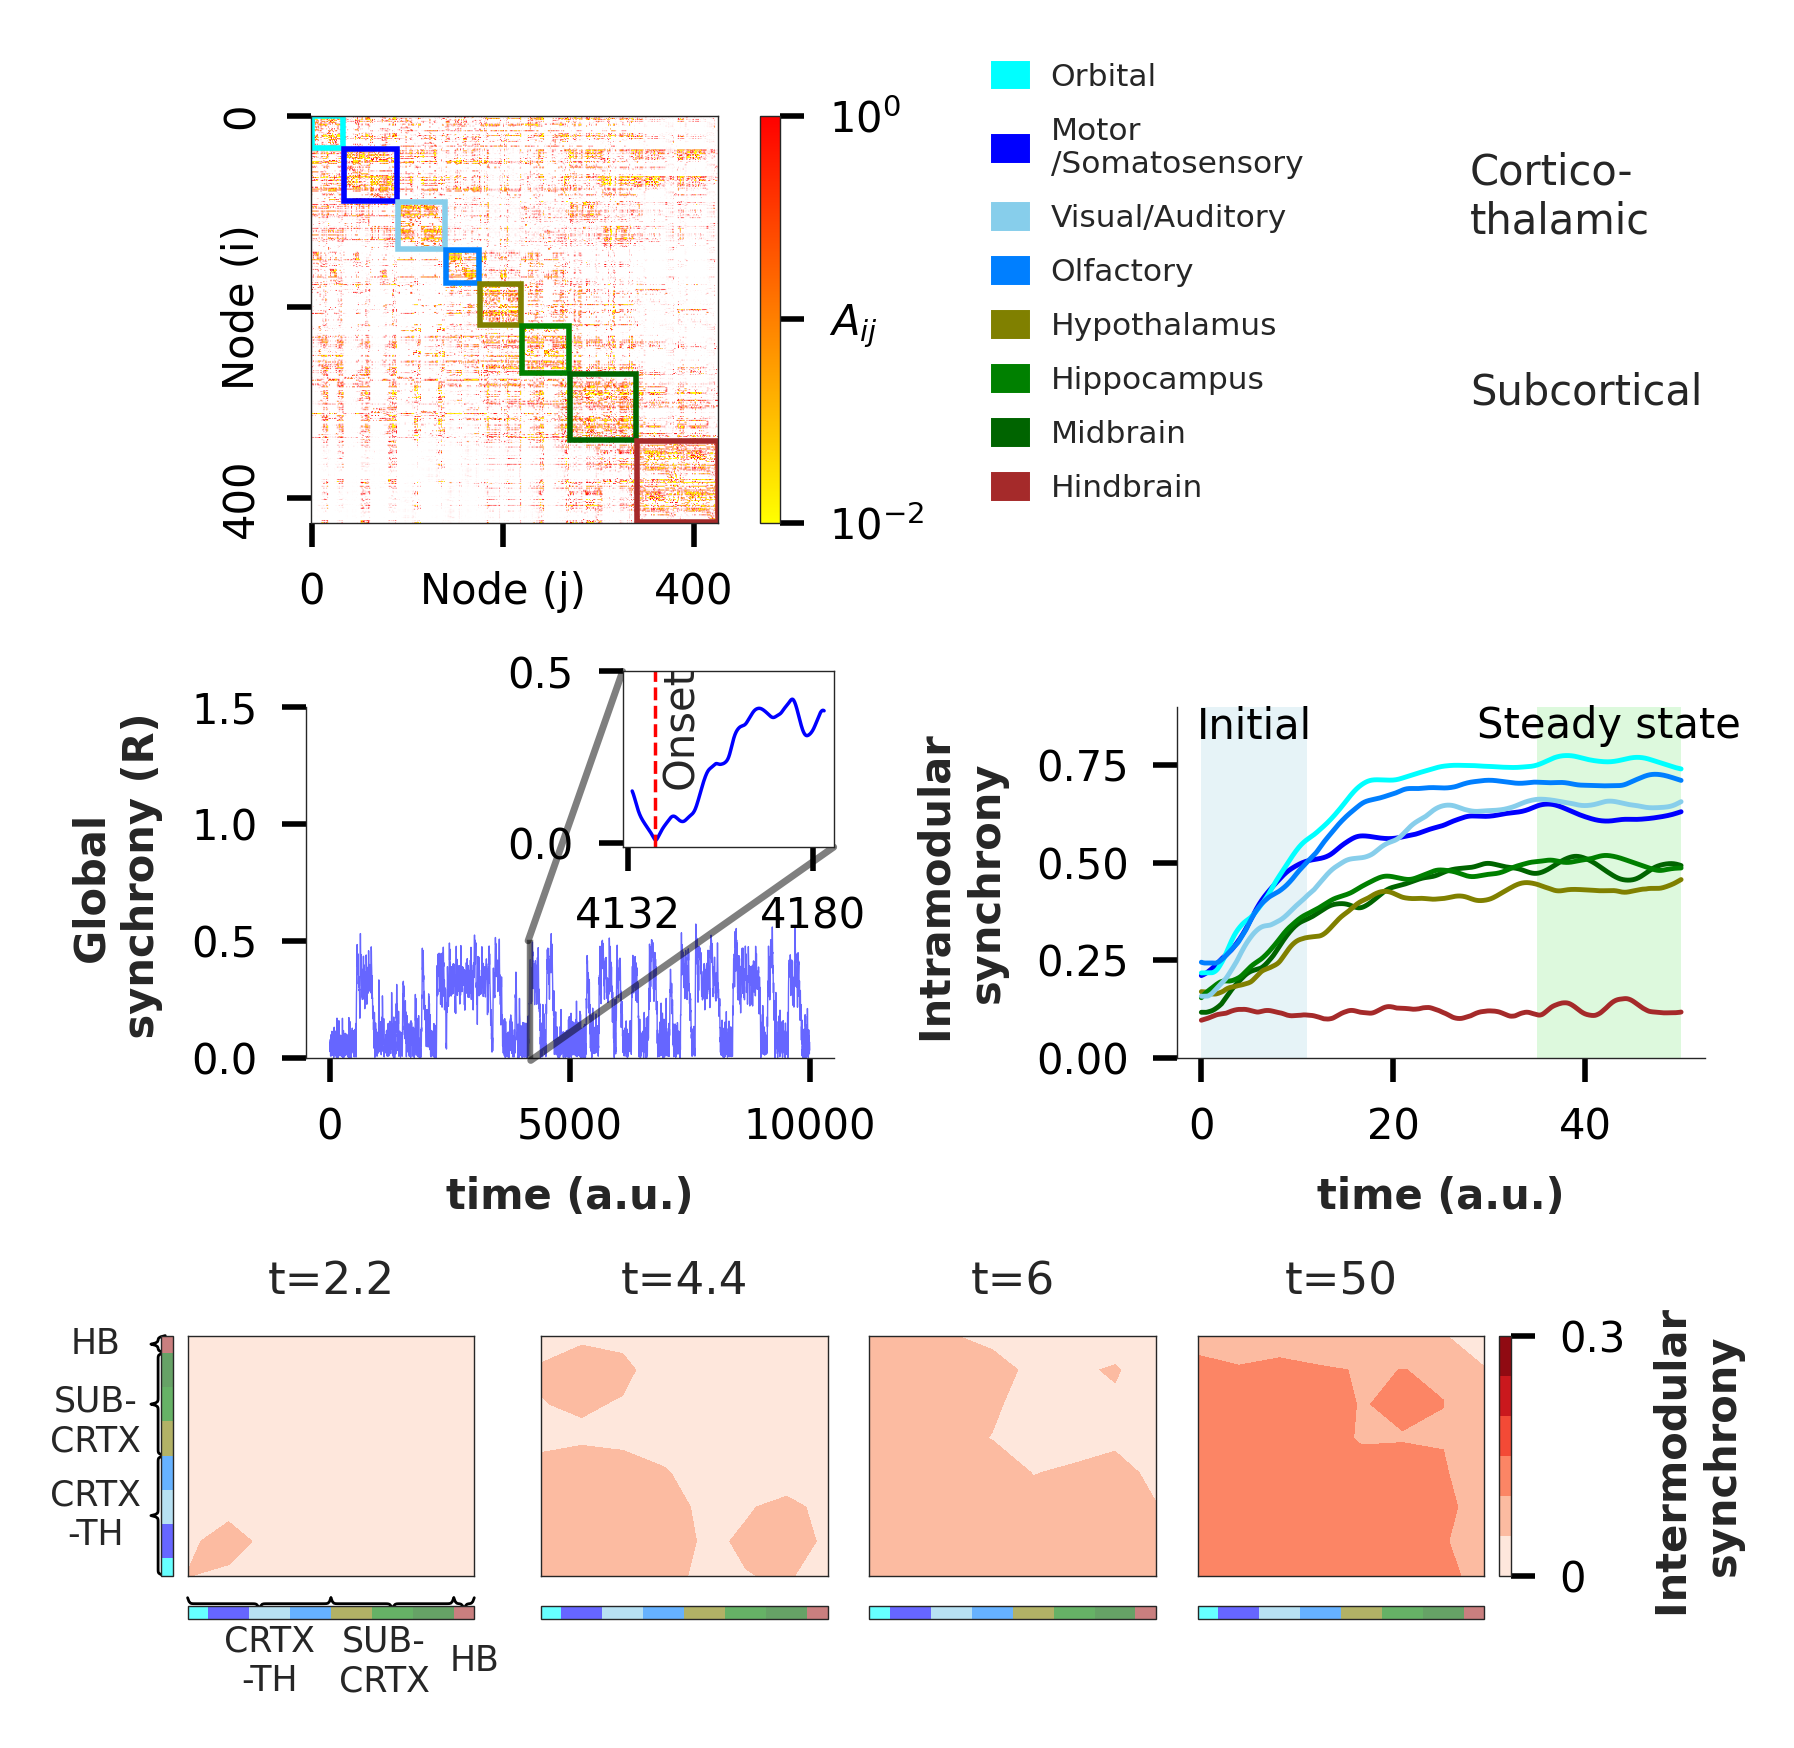

In [15]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
# sns.set_style("dark")
sns.set_style("white", {"axes.labelsize": 12})

style_dict = sns.axes_style()
style_dict['xtick.bottom'] = True
style_dict['ytick.left'] = True
style_dict['xtick.color'] = '0'
style_dict['ytick.color'] = '0'
sns.set_style(style_dict)


import matplotlib

fig = plt.figure(figsize=(3.42, 3.3), dpi=500)
fig.set_constrained_layout(True)

subfigs = fig.subfigures(3, 1, height_ratios=[1.1, 1.1, 0.8], hspace=0) #hspace=0.05
gs1 = GridSpec(1, 2, figure=subfigs[1], width_ratios=[1, 1]) #hspace=0.1, wspace=-0.2

ax1 = subfigs[1].add_subplot(gs1[0]) # tES
ax5 = subfigs[1].add_subplot(gs1[1]) #Intramodular

gs2 = GridSpec(1, 2, figure=subfigs[0], width_ratios=[1, 1.2]) #hspace=0.1, wspace=-0.2

ax3 = subfigs[0].add_subplot(gs2[0]) # Communities
ax4 = subfigs[0].add_subplot(gs2[1]) # Legend

gs2 = GridSpec(1, 4, figure=subfigs[2], width_ratios=[1, 1, 1, 1]) #hspace=0.1, wspace=-0.2

ax6 = subfigs[2].add_subplot(gs2[0])
ax7 = subfigs[2].add_subplot(gs2[1])
ax8 = subfigs[2].add_subplot(gs2[2])
ax9 = subfigs[2].add_subplot(gs2[3])

DT = 0.05
nepochs = len(theta_1)

"""
----------------------------------------------------------------------------
Some sample Transients
----------------------------------------------------------------------------
"""
ax1.plot(np.linspace(0, nepochs//2, nepochs//2)*DT, 
         global_order_3[0:nepochs//2], linewidth=LINE_WIDTH*0.2, color="blue", alpha=0.6)
ax1.set_ylim(0, 1.5)

ax_zoom1 = ax1.inset_axes([0.6, 0.6, 0.4, 0.5])

idx = 23
print(transitoin_time_points_3[idx-21])
start_idx = transitoin_time_points_3[idx-21] - 100
end_idx = start_idx + window_size
ax_zoom1.plot((start_idx + np.linspace(0, window_size, window_size))*DT, 
              global_order_3[start_idx:end_idx], color="blue", linewidth=LINE_WIDTH*0.5)

ax_zoom1.axvline((start_idx+120)*DT, color="red", linewidth=LINE_WIDTH*0.5, linestyle='--',)
ax_zoom1.text(0.18, 0.38, "Onset", fontsize=TEXT_FONT_SIZE, transform=ax_zoom1.transAxes, rotation=90)

ax_zoom1.set_xticks([4132, 4180])
ax_zoom1.set_yticks([0, 0.5])
ax1.indicate_inset_zoom(ax_zoom1, edgecolor="black", facecolor="darkgray", linewidth=LINE_WIDTH*0.5)
ax1.set_ylabel("Global \n synchrony (R)", ha='center', weight='bold')
ax1.set_xlabel("time (a.u.)", weight='bold')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

"""
----------------------------------------------------------------------------
8 Communities
----------------------------------------------------------------------------
"""
whole_brain_conn = np.log10(mb_atlas.WHOLE_BRAIN_CONN)
whole_brain_conn[whole_brain_conn == -np.inf] = 0

WHOLE_BRAIN_CONN_copy = np.copy(whole_brain_conn)
WHOLE_BRAIN_CONN_copy[WHOLE_BRAIN_CONN_copy < -2] = -2
WHOLE_BRAIN_CONN_copy[WHOLE_BRAIN_CONN_copy > 1] = 1

extent = [0, 20, 0, 20]  # Adjust the values as needed
cmap = plt.cm.autumn
im = ax3.imshow(WHOLE_BRAIN_CONN_copy[node_order, :][:, node_order], 
                alpha=(1-mb_atlas.WHOLE_BRAIN_P_VAL[node_order, :][:, node_order]), 
                cmap=cmap.reversed())

colorbar = plt.colorbar(im, ax=ax3, fraction=0.05, pad=0.04)

tick_positions = [0, -1, -2]
tick_labels = [r'$10^{0}$', r'$A_{ij}$', r'$10^{-2}$']

colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels(tick_labels)

boxes_range = []
prev_count = 0
for community_id in reordered_community_ids:
    nodes = mb_atlas.COMMUNITIES[community_id]
    boxes_range.append((prev_count, prev_count + len(nodes) - 1))
    prev_count = prev_count + len(nodes)

for index,  community_id in enumerate(reordered_community_ids):
    box = mpatches.Rectangle((boxes_range[index][0], 
                             boxes_range[index][0]), 
                             boxes_range[index][1] - boxes_range[index][0], 
                             boxes_range[index][1] - boxes_range[index][0], 
                             linewidth=LINE_WIDTH*0.8, 
                             edgecolor=community_cmap(community_id/8), 
                             facecolor='none')
    ax3.add_patch(box)

tick_positions = [0, 200, 400]
tick_labels = [r'0', r'Node (i)', r'400']
ax3.set_yticks(tick_positions)
ax3.set_yticklabels(tick_labels, rotation=90, va='center')

tick_positions = [0, 200, 400]
tick_labels = [r'0', r'Node (j)', r'400']
ax3.set_xticks(tick_positions)
ax3.set_xticklabels(tick_labels)

"""
----------------------------------------------------------------------------
8 Communities legend
----------------------------------------------------------------------------
"""

# Create custom legend handles with labels and colors
legend_patches = [mpatches.Patch(color=community_cmap(c/8), 
                                 label=community_labels[idx]) for idx, c in enumerate(reordered_community_ids)]
ax4.legend(handles=legend_patches, 
           frameon=False, loc='upper left', 
           bbox_to_anchor=(0, 1.2), 
           ncol=1, fontsize=TEXT_FONT_SIZE-1.5, 
           handlelength=1.0,
           labelspacing=0.8)

ax4.set_axis_off()
ax4.text(0.65, 0.8, 'Cortico-\nthalamic', va='center', fontsize=TEXT_FONT_SIZE)
ax4.text(0.65, 0.32, 'Subcortical', va='center', fontsize=TEXT_FONT_SIZE)

"""
----------------------------------------------------------------------------
Intra-modular synchrony
----------------------------------------------------------------------------
"""
for i in range(mb_atlas.N_COMMUNITIES):
    mean = WITHIN_COMM_SYNC_AVG[i, 0:window_size]
    std = np.sqrt(WITHIN_COMM_SYNC_VAR[i, 0:window_size])
    if i==2: 
        ax5.plot(np.linspace(0, window_size, window_size)*DT, 
                 mean, 
                 label=community_labels[i], 
                 color=community_cmap(i/8), 
                linewidth=LINE_WIDTH*0.7, zorder=100)
    else:
        ax5.plot(np.linspace(0, window_size, window_size)*DT, 
                 mean, 
                 label=community_labels[i], 
                 color=community_cmap(i/8), 
                linewidth=LINE_WIDTH*0.7)
        
ax5.set_ylabel('Intramodular \nsynchrony', ha='center', weight='bold')
ax5.set_xlabel('time (a.u.)', weight='bold')

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

ax5.set_ylim(0, 0.90)

ax5.fill_between(np.linspace(700, 1000, 10) * DT, 
                 0, ax5.get_ylim()[1], 
                 color='lightgreen', 
                 alpha=0.3, 
                 edgecolor='none')
ax5.text(850*DT, 0.85, 'Steady state', 
         ha='center', va='center', color='black')


ax5.fill_between(np.linspace(0, 220, 10) * DT, 
                 ax5.get_ylim()[0], ax5.get_ylim()[1], 
                 color='lightblue', alpha=0.3, edgecolor='none')
ax5.text(110*DT, 0.85, 'Initial', 
         ha='center', va='center', color='black')

"""
----------------------------------------------------------------------------
Inter-modular synchrony
----------------------------------------------------------------------------
"""
upper_sync_level = 0.3

"""
----------------------------------------------------------------------------
Inter-modular synchrony
----------------------------------------------------------------------------
"""
between_community_sync_ordered = BETWEEN_COMM_SYNC_AVG[:, :, 44]
between_community_sync_ordered = between_community_sync_ordered[reordered_community_ids, :][:, reordered_community_ids]


levels = np.linspace(0, 1, 21)
cmap = plt.get_cmap('Reds')
cmap.set_under(alpha=0)
ax6.contourf(between_community_sync_ordered, levels=levels, cmap=cmap, vmin=0, vmax=upper_sync_level)
ax6.set_xticks([])
ax6.set_yticks([])

ax6.grid()
ax6.set_title('t=2.2')

show_tracking_color_bar(ax6, 0)
show_tracking_color_bar2(ax6, 0)

"""
----------------------------------------------------------------------------
Inter-modular synchrony
----------------------------------------------------------------------------
"""
between_community_sync_ordered = BETWEEN_COMM_SYNC_AVG[:, :, 88]
between_community_sync_ordered = between_community_sync_ordered[reordered_community_ids, :][:, reordered_community_ids]

levels = np.linspace(0, 1, 21)
cmap = plt.get_cmap('Reds')
cmap.set_under(alpha=0)
ax7.contourf(between_community_sync_ordered, levels=levels, cmap=cmap, vmin=0, vmax=upper_sync_level)
ax7.set_xticks([])
ax7.set_yticks([])
ax7.grid()
ax7.set_title('t=4.4')

show_tracking_color_bar(ax7, 1)

"""
----------------------------------------------------------------------------
Inter-modular synchrony
----------------------------------------------------------------------------
"""
between_community_sync_ordered = BETWEEN_COMM_SYNC_AVG[:, :, 120]
between_community_sync_ordered = between_community_sync_ordered[reordered_community_ids, :][:, reordered_community_ids]

levels = np.linspace(0, 1, 21)
cmap = plt.get_cmap('Reds')
cmap.set_under(alpha=0)
im2 = ax8.contourf(between_community_sync_ordered, levels=levels, cmap=cmap, vmin=0, vmax=upper_sync_level)
ax8.set_xticks([])
ax8.set_yticks([])
ax8.grid()
ax8.set_title('t=6')

show_tracking_color_bar(ax8, 1)

"""
----------------------------------------------------------------------------
Inter-modular synchrony
----------------------------------------------------------------------------
"""
between_community_sync_ordered = BETWEEN_COMM_SYNC_AVG[:, :, 999]
between_community_sync_ordered = between_community_sync_ordered[reordered_community_ids, :][:, reordered_community_ids]

levels = np.linspace(0, 1, 21)
cmap = plt.get_cmap('Reds')
cmap.set_under(alpha=0)
im2 = ax9.contourf(between_community_sync_ordered, levels=levels, cmap=cmap, vmin=0, vmax=upper_sync_level)
ax9.set_xticks([])
ax9.set_yticks([])
ax9.grid()
ax9.set_title('t=50')

show_tracking_color_bar(ax9, 1)

colorbar = fig.colorbar(im2, ax=ax9)
colorbar.ax.set_ylim(0, upper_sync_level)

tick_positions = [0, upper_sync_level]
tick_labels = [r'0', str(upper_sync_level)]

colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels(tick_labels)
colorbar.set_label('Intermodular \nsynchrony', ha='center', fontsize=TEXT_FONT_SIZE, weight='bold')

plt.savefig("Figure 4.svg", format='svg')

plt.show()

#### Supplementary Figure

In [471]:
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True)
from scipy import stats
from scipy.stats import combine_pvalues

p_vals_f_min = np.zeros([8, 8])
p_vals_f_max = np.zeros([8, 8])
p_vals_i_min = np.zeros([8, 8])
p_vals_i_max = np.zeros([8, 8])

window_f = 200 #200
window_i = 210 #220, 210
data_f = WITHIN_COMM_SYNC_CUMLTV[:,:,1000-window_f:1000-window_f+window_f]
data_i = WITHIN_COMM_SYNC_CUMLTV[:,:,0:0+window_i]

p_vals_f = np.zeros([8, 8])
p_vals_i = np.zeros([8, 8])
p_vals_intercept_i = np.zeros([8, 8])
p_vals_i_0 = np.zeros([8, 8])

#####################################################################################

# Define the constant (horizontal line) function
def constant(x, a):
    return a

fitted_const_data_f = np.zeros([52, 8])
error_data_f = np.zeros([52, 8])
variance_in_error_data_f = np.zeros([52, 8])

fitted_const_data_f = np.zeros([52, 8])
error_data_f = np.zeros([52, 8])
variance_in_error_data_f = np.zeros([52, 8])

fitted_const_slope_data_i = np.zeros([52, 8])
error_data_i = np.zeros([52, 8])
variance_in_error_data_i = np.zeros([52, 8])
fitted_const_intercept_data_i = np.zeros([52, 8])

# Fit constatn function to each of the 52 transinets for each of 8 communities
for c_idx in range(8):
    for tr_idx in range(52):
        # Fit the constant function to the data
        params, covariance = curve_fit(constant, np.linspace(0, window_f-1, window_f), 
                                       data_f[tr_idx][c_idx])
        
        # Extract the fitted constant value
        constant_value = params[0]
        # print(constant_value)
        
        # Fit a linear regression model for obtaining slope
        coefficients = np.polyfit(np.linspace(0, window_i-1, window_i), 
                                  data_i[tr_idx][c_idx], 1)
        
        # The coefficients[0] is the slope of the line
        slope = coefficients[0]
        intercept = coefficients[1]
        
        # Calculate error (standard error)
        error = np.sqrt(np.mean((data_f[tr_idx][c_idx] - constant_value)**2))
        var_in_error = np.var(data_f[tr_idx][c_idx] - constant_value)
        
        fitted_const_data_f[tr_idx][c_idx] = constant_value
        error_data_f[tr_idx][c_idx] = error
        variance_in_error_data_f[tr_idx][c_idx] = var_in_error
        
        """
        Calculate error
        """
        # Calculate the predicted values (y-values) based on the fitted line
        predicted_y = slope * np.linspace(0, window_i-1, window_i) + intercept
        
        # Calculate the residuals (errors)
        residuals = data_i[tr_idx][c_idx] - predicted_y

        error = np.sqrt(np.mean(residuals**2) )
        var_in_error = np.var(residuals)
        
        fitted_const_slope_data_i[tr_idx][c_idx] = slope
        error_data_i[tr_idx][c_idx] = error
        variance_in_error_data_i[tr_idx][c_idx] = var_in_error
        
        fitted_const_intercept_data_i[tr_idx][c_idx] = intercept
        
#####################################################################################

for i in range(mb_atlas.N_COMMUNITIES):
    for j in range(mb_atlas.N_COMMUNITIES):
        if i==j:
            continue
        
        """
        Initial state
        """
        weights1 = 1 / (error_data_i[:, i] ** 2)
        weights2 = 1 / (error_data_i[:, j] ** 2)
        n = len(fitted_const_slope_data_i[:, i])
        
        # Calculate weighted means and variances
        weighted_mean1 = np.average(fitted_const_slope_data_i[:, i], weights=weights1)
        num = np.sum( weights1*(fitted_const_slope_data_i[:, i] - weighted_mean1) ** 2 )
        weighted_variance1 = (n/(n-1))*( num / np.sum(weights1) ) 
        
        weighted_mean2 = np.average(fitted_const_slope_data_i[:, j], weights=weights2)
        denom = np.sum( weights2*(fitted_const_slope_data_i[:, j] - weighted_mean2) ** 2 )
        weighted_variance2 = (n/(n-1))*( denom / np.sum(weights2) ) 
        
        # Perform a weighted t-test
        t_stat, p_value = stats.ttest_ind_from_stats(
            mean1=weighted_mean1, std1=np.sqrt(weighted_variance1), nobs1=n,
            mean2=weighted_mean2, std2=np.sqrt(weighted_variance2), nobs2=n, equal_var=False
        )
        
        p_vals_i[i][j] = p_value
        
        # Intercept
        t_statistic, p_value = stats.ttest_ind(fitted_const_intercept_data_i[:, i], 
                                         fitted_const_intercept_data_i[:, j], equal_var=False)
        p_vals_intercept_i[i][j] = p_value
        
        
        t_statistic, p_value = stats.ttest_ind(data_i[:, i, 0], data_i[:, j, 0], equal_var=False)
        p_vals_i_0[i][j] = p_value
        
        """
        Steady state
        """
        weights1 = 1 / (error_data_f[:, i] ** 2)
        weights2 = 1 / (error_data_f[:, j] ** 2)
        n = len(fitted_const_data_f[:, i])
        
        # Calculate weighted means and variances
        weighted_mean1 = np.average(fitted_const_data_f[:, i], weights=weights1)
        num = np.sum( weights1*(fitted_const_data_f[:, i] - weighted_mean1) ** 2 )
        weighted_variance1 = (n/(n-1))*( num / np.sum(weights1) ) 
        
        weighted_mean2 = np.average(fitted_const_data_f[:, j], weights=weights2)
        denom = np.sum( weights2*(fitted_const_data_f[:, j] - weighted_mean2) ** 2 )
        weighted_variance2 = (n/(n-1))*( denom / np.sum(weights2) ) #np.average((fitted_const_data_f[:, j] - weighted_mean2) ** 2, weights=weights2)

        # Perform a weighted t-test
        t_stat, p_value = stats.ttest_ind_from_stats(
            mean1=weighted_mean1, std1=np.sqrt(weighted_variance1), nobs1=n,
            mean2=weighted_mean2, std2=np.sqrt(weighted_variance2), nobs2=n, equal_var=False
        )
        
        p_vals_f[i][j] = p_value
    
# Choose the maximum p-value (if it is less than 0.05 then great)
PAIRWISE_T_TEST_F = np.zeros([8, 8])
PAIRWISE_T_TEST_I = np.zeros([8, 8])
PAIRWISE_T_TEST_I_INTERCEPT = np.zeros([8, 8])
PAIRWISE_T_TEST_I_0 = np.zeros([8, 8])

# Print the pairwise statistical significance
for idx_i, i in enumerate(reordered_community_ids):
    for idx_j, j in enumerate(reordered_community_ids):
        if idx_i == idx_j or idx_i > idx_j:
            PAIRWISE_T_TEST_F[idx_i][idx_j] = np.nan
            PAIRWISE_T_TEST_I[idx_i][idx_j] = np.nan
            PAIRWISE_T_TEST_I_INTERCEPT[idx_i][idx_j] = np.nan
            PAIRWISE_T_TEST_I_0[idx_i][idx_j] = np.nan
            continue
        
        PAIRWISE_T_TEST_F[idx_i][idx_j] = p_vals_f[i][j]
        PAIRWISE_T_TEST_I[idx_i][idx_j] = p_vals_i[i][j]
        PAIRWISE_T_TEST_I_INTERCEPT[idx_i][idx_j] = p_vals_intercept_i[i][j]
        PAIRWISE_T_TEST_I_0[idx_i][idx_j] = p_vals_i_0[i][j]

print("done")

done


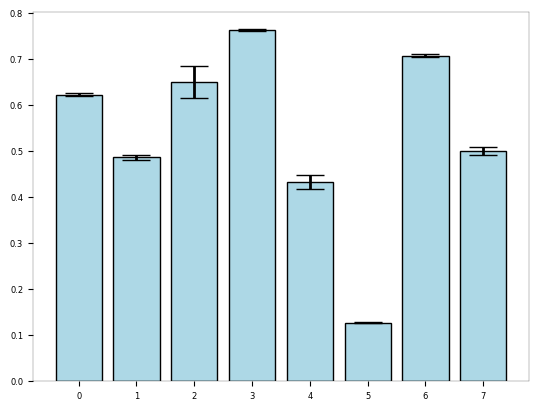

In [463]:
"""
reordered_community_ids = [3, 0, 2, 6, 4, 7, 1, 5]
["CR1", "MB", "CR2", "CR3", "HYP", "PONS/MD", "OLF/LS", "HPF/LS"]

0: Motor\n/Somatosensory
1: Midbrain
2: Visual/Auditory
3: Orbital
4: Hypothalamus
5: Hindbrain
6: Olfactory
7: Hippocampus

vis (2) - orbital (3), visual (2) - motor (0)
"""

means = np.mean(fitted_const_data_f, axis=0) 
variances = np.var(fitted_const_data_f, axis=0) 
labels = [0, 1, 2, 3, 4, 5, 6, 7]

plt.bar(labels, means, yerr=variances, capsize=10, color='lightblue', edgecolor='black')
plt.show()

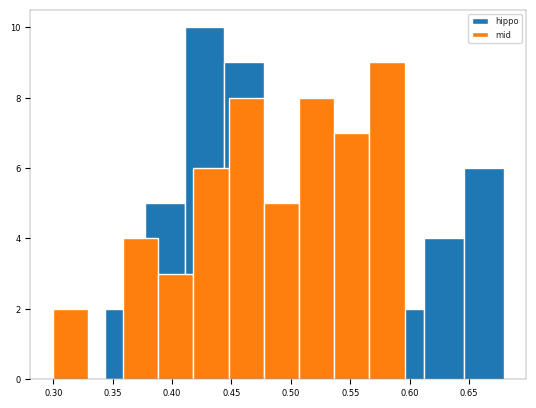

In [466]:
fitted_const_data_f[:,2]
np.where(fitted_const_data_f[:,2] < 0.4)

plt.hist(fitted_const_data_f[:,7], bins=10, label='hippo') 
plt.hist(fitted_const_data_f[:,1], bins=10, label='mid') 
plt.legend()
plt.show()

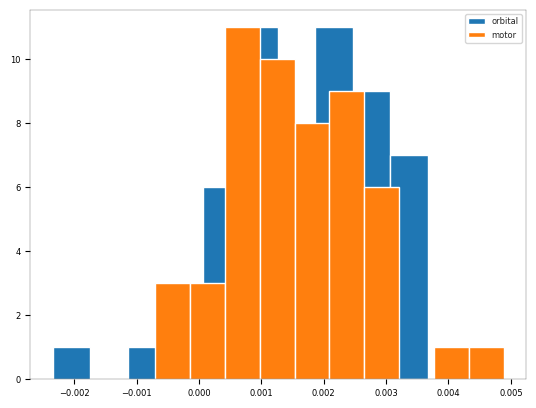

In [458]:
plt.hist(fitted_const_slope_data_i[:,3], bins=10, label='orbital') 
plt.hist(fitted_const_slope_data_i[:,0], bins=10, label='motor') 
# plt.hist(fitted_const_slope_data_i[:,2], bins=10, label='visual') 
# plt.hist(fitted_const_slope_data_i[:,6], bins=10, label='olfactory') 
# plt.hist(fitted_const_slope_data_i[:,7], bins=10, label='hippo') 
# plt.hist(fitted_const_slope_data_i[:,1], bins=10, label='mid') 
plt.legend()
plt.show()

In [380]:
weights =  1 / (error_data_f ** 2)

weights[np.argsort(fitted_const_data_f[:,2]), 2]

array([  148.66218548,   204.36152417,  1325.39807942,    91.01182951,
          70.95647366,   231.39287581,    39.58129336,   190.63757515,
         109.28422659,   102.78617595,   112.24282587,    44.42120144,
         269.23028412,   361.25545775,    62.74137855,    98.20131358,
         256.2883813 ,   532.11312962,   439.70859714,   283.9715705 ,
         674.58100782,  1282.76384583,   161.22525367,   943.75614737,
         520.76885322,  1339.65990603,   367.68438385,   447.80675277,
        1783.93611911,   152.92444237,   592.05835146,  3922.10434357,
        1094.80849915,  1089.53092845,   975.67533357,  1246.32394314,
        1251.29050461,  2248.43286647,   994.6060026 ,   994.6060026 ,
        5202.85073774,  1785.91619767,   951.09590618,  1879.93982386,
        1884.34968943,  1038.23993037,  4829.53644543,  4879.87310395,
       10315.76239639,  3161.1209671 ,  1663.12392295,  3045.52206717])

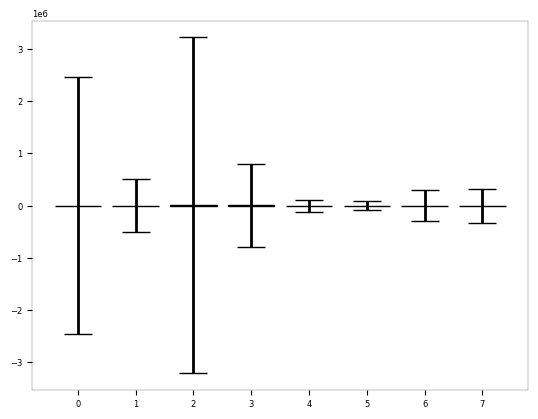

In [375]:
means = np.mean( 1 / (error_data_f ** 2), axis=0)
variances = np.var( 1 / (error_data_f ** 2), axis=0)
# means = np.mean(fitted_const_data_f, axis=0)
# variances = np.var(fitted_const_data_f, axis=0)
labels = [0, 1, 2, 3, 4, 5, 6, 7]

plt.bar(labels, means, yerr=variances, capsize=10, color='lightblue', edgecolor='black')
plt.show()

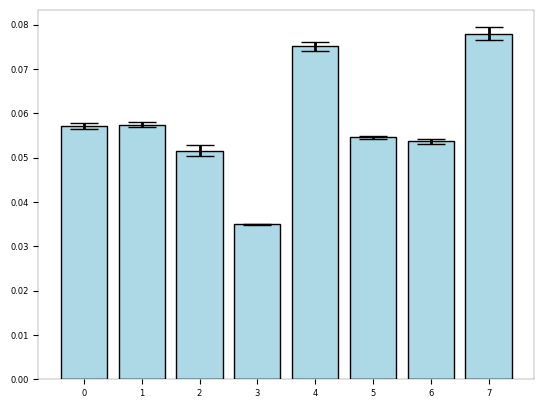

In [238]:
means = np.mean(error_data_f, axis=0)
variances = np.var(error_data_f, axis=0) #np.mean(variance_in_error_data_f, axis=0) 
labels = [0, 1, 2, 3, 4, 5, 6, 7]

plt.bar(labels, means, yerr=variances, capsize=10, color='lightblue', edgecolor='black')
plt.show()

In [76]:
from scipy.stats import combine_pvalues

# List of individual p-values
p_values = [0.1, 0.05, 0.05, 0.05, 0.06, 0.06, 0.07, 0.08, 
            0.2, 0.3, 0.15, 0.14, 0.21, 0.13, 0.1, 0.06]

# Calculate the chi-squared statistic and its corresponding p-value
chi2, combined_p_value = combine_pvalues(p_values, method='fisher')

print("Combined Fisher's Test P-Value:", combined_p_value)

Combined Fisher's Test P-Value: 2.6295421281717693e-05


**Plot**

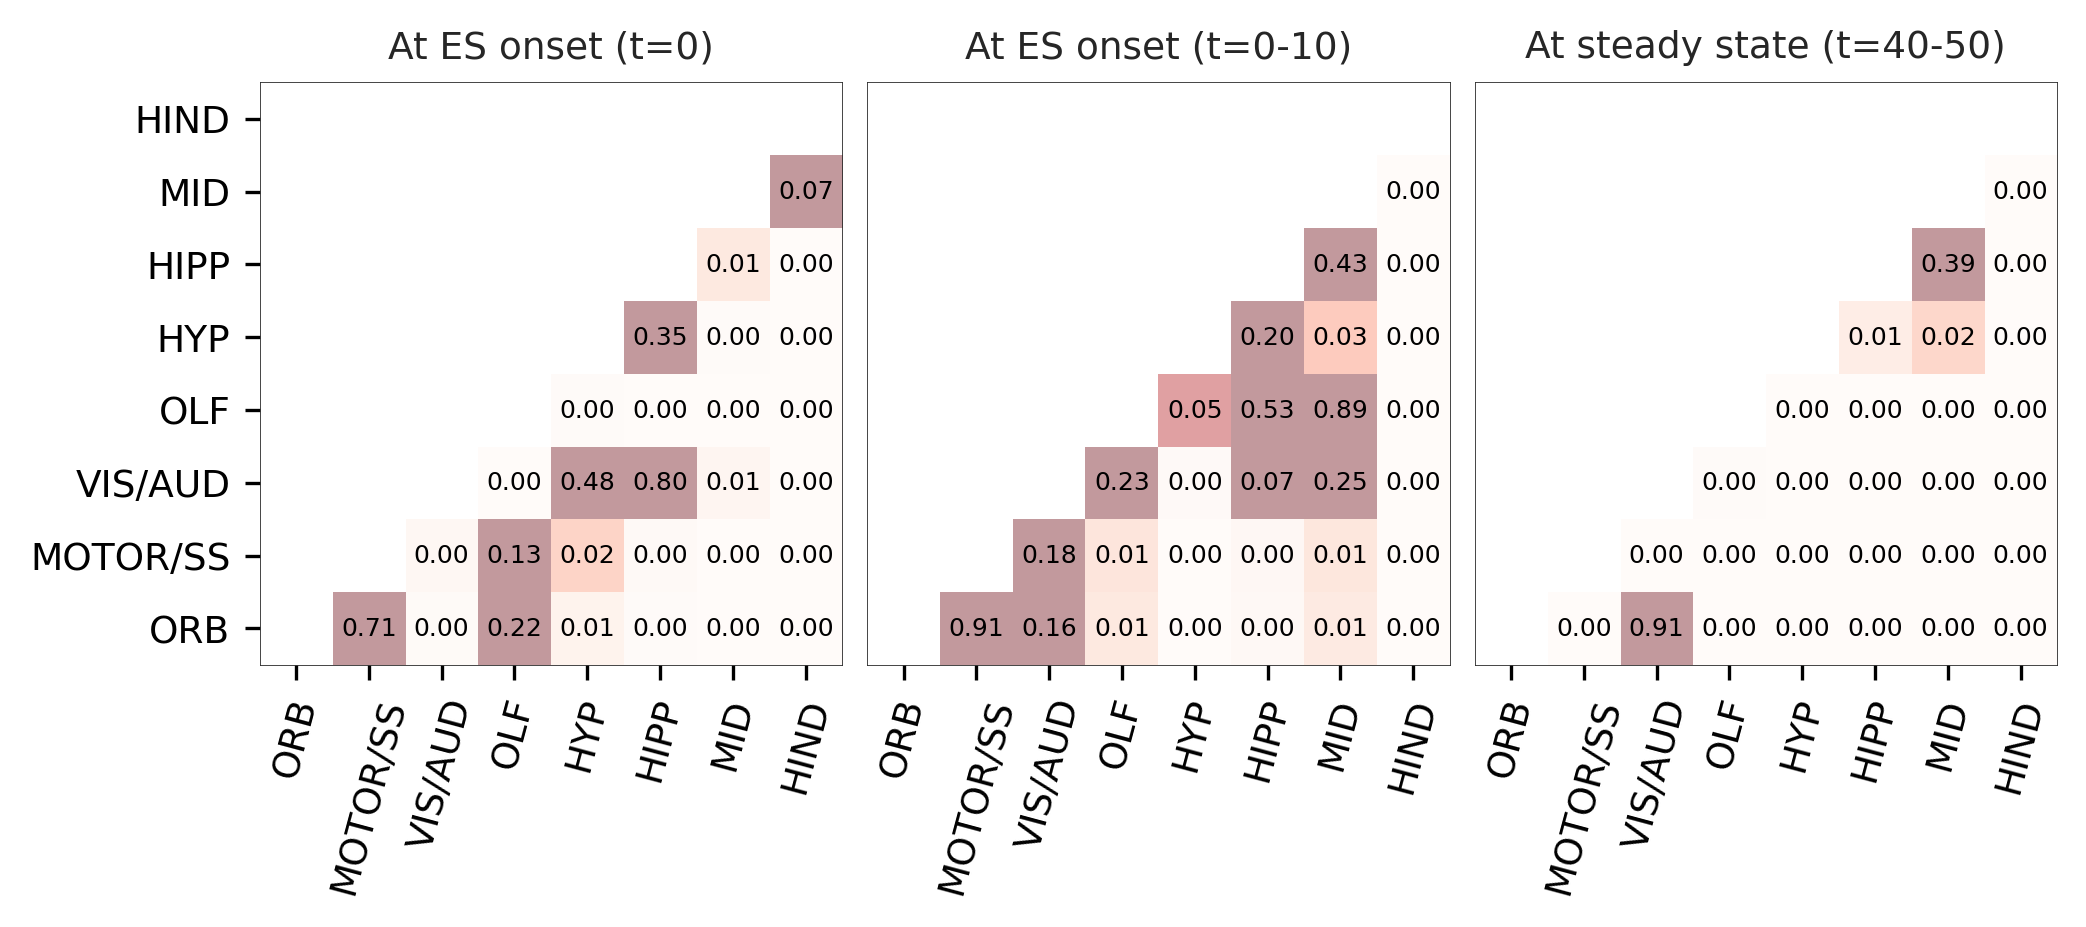

In [479]:
community_labels = ["ORB", 
                    "MOTOR/SS", 
                    "VIS/AUD", 
                    "OLF", 
                    "HYP", 
                    "HIPP", 
                    "MID", 
                    "HIND"]

import seaborn as sns
# sns.set_style("dark")
sns.set_style("white", {"axes.labelsize": 12})

style_dict = sns.axes_style()
style_dict['xtick.bottom'] = True
style_dict['ytick.left'] = True
style_dict['xtick.color'] = '0'
style_dict['ytick.color'] = '0'
sns.set_style(style_dict)

# fig = plt.figure(figsize=(12,7.5))
fig = plt.figure(figsize=(6.84,4), dpi=300)
fig.set_constrained_layout(True)

gs1 = GridSpec(1, 3, figure=fig) #hspace=0.1, wspace=-0.2

ax1 = fig.add_subplot(gs1[1])
ax2 = fig.add_subplot(gs1[2]) 
ax3 = fig.add_subplot(gs1[0]) 


# Plot the heatmap
# PAIRWISE_T_TEST_I
# PAIRWISE_T_TEST_I_INTERCEPT
heatmap = ax1.imshow(PAIRWISE_T_TEST_I, cmap='Reds', vmin=0, vmax=0.06, origin='lower', alpha=0.4)
heatmap = ax2.imshow(PAIRWISE_T_TEST_F, cmap='Reds', vmin=0, vmax=0.06, origin='lower', alpha=0.4)
heatmap = ax3.imshow(PAIRWISE_T_TEST_I_0, cmap='Reds', vmin=0, vmax=0.06, origin='lower', alpha=0.4)


# Add the values inside the boxes
for i in range(PAIRWISE_T_TEST_I.shape[0]):
    for j in range(PAIRWISE_T_TEST_I.shape[1]):
        if j > i:
            ax1.annotate(f'{PAIRWISE_T_TEST_I[i, j]:.2f}', (j, i), color='black', 
                        fontsize=6,
                        ha='center', va='center')
            ax2.annotate(f'{PAIRWISE_T_TEST_F[i, j]:.2f}', (j, i), color='black', 
                        fontsize=6,
                        ha='center', va='center')
            ax3.annotate(f'{PAIRWISE_T_TEST_I_0[i, j]:.2f}', (j, i), color='black', 
                        fontsize=6,
                        ha='center', va='center')

# Set the tick labels
ax1.set_xticks(range(PAIRWISE_T_TEST_I.shape[1]))
ax1.set_yticks(range(PAIRWISE_T_TEST_I.shape[0]))
ax1.set_xticklabels(range(1, PAIRWISE_T_TEST_I.shape[1] + 1))
ax1.set_yticklabels(range(1, PAIRWISE_T_TEST_I.shape[0] + 1))

ax2.set_xticks(range(PAIRWISE_T_TEST_F.shape[1]))
ax2.set_yticks(range(PAIRWISE_T_TEST_F.shape[0]))
ax2.set_xticklabels(range(1, PAIRWISE_T_TEST_F.shape[1] + 1))
ax2.set_yticklabels(range(1, PAIRWISE_T_TEST_F.shape[0] + 1))

ax3.set_xticks(range(PAIRWISE_T_TEST_I_0.shape[1]))
ax3.set_yticks(range(PAIRWISE_T_TEST_I_0.shape[0]))
ax3.set_xticklabels(range(1, PAIRWISE_T_TEST_I_0.shape[1] + 1))
ax3.set_yticklabels(range(1, PAIRWISE_T_TEST_I_0.shape[0] + 1))


ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax3.set_xticks([])

# add labels for index groups to the x and y axis
yticks = [0, 1, 2, 3, 4, 5, 6, 7]
yticklabels = community_labels
ax3.set_yticks(yticks, yticklabels, fontsize=1.5*TEXT_FONT_SIZE)

xticks = [0, 1, 2, 3, 4, 5, 6, 7]
xticklabels = community_labels
ax1.set_xticks(xticks, xticklabels, rotation=75, fontsize=1.5*TEXT_FONT_SIZE)
ax2.set_xticks(xticks, xticklabels, rotation=75, fontsize=1.5*TEXT_FONT_SIZE)
ax3.set_xticks(xticks, xticklabels, rotation=75, fontsize=1.5*TEXT_FONT_SIZE)

ax1.set_title("At ES onset (t=0-10)", fontsize=2*TITLE_FONT_SIZE-4)
ax2.set_title("At steady state (t=40-50)", fontsize=2*TITLE_FONT_SIZE-4)
ax3.set_title("At ES onset (t=0)", fontsize=2*TITLE_FONT_SIZE-4)

plt.show()

# More sample we include, more significant the result become

**At t=999 (steady state)**

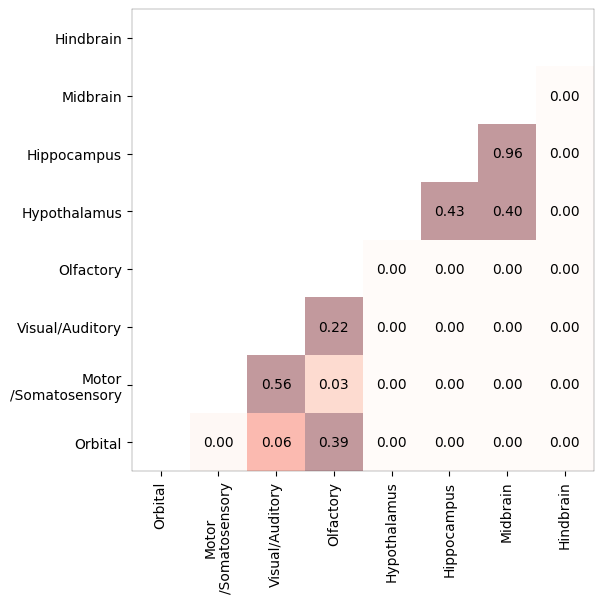

In [117]:


# Set up the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

community_labels = ["Orbital", 
                    "Motor\n/Somatosensory", 
                    "Visual/Auditory", 
                    "Olfactory", 
                    "Hypothalamus", 
                    "Hippocampus", 
                    "Midbrain", 
                    "Hindbrain"]

temp = PAIRWISE_T_TEST#[reordered_community_ids, :][:, reordered_community_ids]

# Plot the heatmap
heatmap = ax.imshow(temp, cmap='Reds', vmin=0, vmax=0.1, origin='lower', alpha=0.4)

# Add the values inside the boxes
for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
        if j > i:
            ax.annotate(f'{temp[i, j]:.2f}', (j, i), color='black', 
                        fontsize=10,
                        ha='center', va='center')

# Set the tick labels
ax.set_xticks(range(temp.shape[1]))
ax.set_yticks(range(temp.shape[0]))
ax.set_xticklabels(range(1, temp.shape[1] + 1))
ax.set_yticklabels(range(1, temp.shape[0] + 1))

# add labels for index groups to the x and y axis
yticks = [0, 1, 2, 3, 4, 5, 6, 7]
yticklabels = community_labels
plt.yticks(yticks, yticklabels, fontsize=10)

xticks = [0, 1, 2, 3, 4, 5, 6, 7]
xticklabels = community_labels
plt.xticks(xticks, xticklabels, rotation=90, fontsize=10)

# Show the plot
plt.show()

**At t=0 (initial state)**

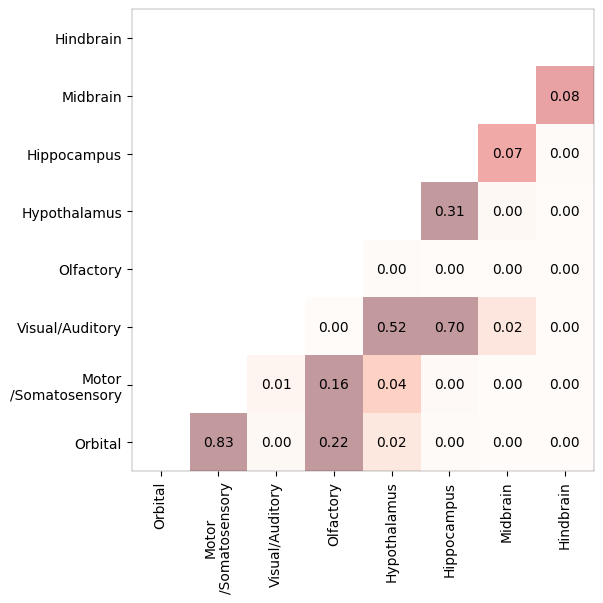

In [119]:
import seaborn as sns
sns.set_style("white", {"axes.labelsize": 12})

style_dict = sns.axes_style()
style_dict['xtick.bottom'] = True
style_dict['ytick.left'] = True
style_dict['xtick.color'] = '0'
style_dict['ytick.color'] = '0'
sns.set_style(style_dict)

fig, ax = plt.subplots(figsize=(6, 6))

"""
reordered_community_ids = [3, 0, 2, 6, 4, 7, 1, 5]
["CR1", "MB", "CR2", "CR3", "HYP", "PONS/MD", "OLF/LS", "HPF/LS"]

0: Motor\n/Somatosensory
1: Midbrain
2: Visual/Auditory
3: Orbital
4: Hypothalamus
5: Hindbrain
6: Olfactory
7: Hippocampus
"""

community_labels = ["Orbital", 
                    "Motor\n/Somatosensory", 
                    "Visual/Auditory", 
                    "Olfactory", 
                    "Hypothalamus", 
                    "Hippocampus", 
                    "Midbrain", 
                    "Hindbrain"]

temp = PAIRWISE_T_TEST

# Plot the heatmap
heatmap = ax.imshow(temp, cmap='Reds', vmin=0, vmax=0.1, origin='lower', alpha=0.4)

# Add the values inside the boxes
for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
        if j > i:
            ax.annotate(f'{temp[i, j]:.2f}', (j, i), color='black', 
                        fontsize=10,
                        ha='center', va='center')

# Set the tick labels
ax.set_xticks(range(temp.shape[1]))
ax.set_yticks(range(temp.shape[0]))
ax.set_xticklabels(range(1, temp.shape[1] + 1))
ax.set_yticklabels(range(1, temp.shape[0] + 1))

# add labels for index groups to the x and y axis
yticks = [0, 1, 2, 3, 4, 5, 6, 7]
yticklabels = community_labels
plt.yticks(yticks, yticklabels, fontsize=10)

xticks = [0, 1, 2, 3, 4, 5, 6, 7]
xticklabels = community_labels
plt.xticks(xticks, xticklabels, rotation=90, fontsize=10)

# Show the plot
plt.show()

**Pairwise t-test between 3 grouped communitied**

This is zero at each time point in time window of 200 epochs at steady state

In [494]:
group1_constants = np.concatenate( (fitted_const_data_f[:, 0], 
                                    fitted_const_data_f[:, 2],
                                    fitted_const_data_f[:, 3],
                                    fitted_const_data_f[:, 6]), axis=0)

group1_errors = np.concatenate( (fitted_const_data_f[:, 0], 
                                 fitted_const_data_f[:, 2],
                                 fitted_const_data_f[:, 3],
                                 fitted_const_data_f[:, 6]), axis=0)

group2_constants = np.concatenate( (fitted_const_data_f[:, 1], 
                                    fitted_const_data_f[:, 4],
                                    fitted_const_data_f[:, 7]), axis=0)

group2_errors = np.concatenate( (fitted_const_data_f[:, 1], 
                                 fitted_const_data_f[:, 4],
                                 fitted_const_data_f[:, 7]), axis=0)


weights1 = 1 / (group1_errors ** 2)
weights2 = 1 / (group2_errors ** 2)
n = len(weights2)

# Calculate weighted means and variances
weighted_mean1 = np.average(group1_constants, weights=weights1)
num = np.sum( weights1*(group1_constants - weighted_mean1) ** 2 )
weighted_variance1 = (n/(n-1))*( num / np.sum(weights1) ) 

weighted_mean2 = np.average(group2_constants, weights=weights2)
denom = np.sum( weights2*(group2_constants - weighted_mean2) ** 2 )
weighted_variance2 = (n/(n-1))*( denom / np.sum(weights2) ) 

# Perform a weighted t-test
t_stat, p_value = stats.ttest_ind_from_stats(
    mean1=weighted_mean1, std1=np.sqrt(weighted_variance1), nobs1=n,
    mean2=weighted_mean2, std2=np.sqrt(weighted_variance2), nobs2=n, equal_var=False
)

p_value

5.035388689373908e-33

In [24]:
import scipy.stats as stats
np.set_printoptions(suppress=True)

# Define the two groups: 0, 2, 3, 6 in one group
group1 = ( WITHIN_COMM_SYNC_CUMLTV[:,0,800:999] 
          + WITHIN_COMM_SYNC_CUMLTV[:,2,800:999]
          + WITHIN_COMM_SYNC_CUMLTV[:,3,800:999]
          + WITHIN_COMM_SYNC_CUMLTV[:,6,800:999] )/4

group2 = (WITHIN_COMM_SYNC_CUMLTV[:,1,800:999] +
          WITHIN_COMM_SYNC_CUMLTV[:,4,800:999] +
          WITHIN_COMM_SYNC_CUMLTV[:,7,800:999]) /3  # List of arrays with 52 data points for each community

t_statistic, p_value = stats.ttest_ind(group1, group2, axis=0)

# Print the results
print("Independent Samples T-Test:")
print(f"p-value: {p_value}")

Independent Samples T-Test:
p-value: [0.00000005 0.00000005 0.00000005 0.00000005 0.00000005 0.00000005
 0.00000005 0.00000005 0.00000004 0.00000004 0.00000004 0.00000004
 0.00000004 0.00000004 0.00000004 0.00000003 0.00000003 0.00000003
 0.00000003 0.00000003 0.00000003 0.00000003 0.00000002 0.00000002
 0.00000002 0.00000002 0.00000002 0.00000002 0.00000002 0.00000002
 0.00000002 0.00000001 0.00000001 0.00000001 0.00000001 0.00000001
 0.00000001 0.00000001 0.00000001 0.00000001 0.00000001 0.00000001
 0.00000001 0.00000001 0.00000001 0.00000001 0.00000001 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        

**At onset: Calculation of slope and stastical difference**

Potential initiators: At start certain region are stastically different from each other and show larger increase in slope

In [58]:
# At onset
np.set_printoptions(suppress=True)

# Define the two groups
# Define the two groups: 0, 2, 3, 6 in one group
group1 = ( WITHIN_COMM_SYNC_CUMLTV[:,0,0:200] 
          + WITHIN_COMM_SYNC_CUMLTV[:,2,0:200]
          + WITHIN_COMM_SYNC_CUMLTV[:,3,0:200]
          + WITHIN_COMM_SYNC_CUMLTV[:,6,0:200] )/4
# 1, 4, 7 in another group
group2 = (WITHIN_COMM_SYNC_CUMLTV[:,1,0:200] +
          WITHIN_COMM_SYNC_CUMLTV[:,4,0:200] +
          WITHIN_COMM_SYNC_CUMLTV[:,7,0:200]) /3  

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)

print("Independent Samples T-Test:")
print(f"p-value: {p_value}")

Independent Samples T-Test:
p-value: [0.00002499 0.00002878 0.00003289 0.00003683 0.00004079 0.00004505
 0.00004972 0.00005483 0.00005949 0.00006365 0.00006819 0.00007319
 0.00007845 0.00008351 0.00008763 0.00009056 0.00009275 0.00009469
 0.00009678 0.0000995  0.00010342 0.00010879 0.00011462 0.00011982
 0.00012494 0.00013017 0.00013469 0.00013804 0.00014085 0.00014334
 0.00014534 0.00014663 0.00014702 0.00014672 0.00014558 0.00014246
 0.00013922 0.00013604 0.00013072 0.00012455 0.00011849 0.00011277
 0.00010963 0.00011004 0.00011005 0.00010917 0.00010747 0.00010653
 0.00010426 0.0001007  0.00009643 0.00009189 0.00008728 0.00008093
 0.00007426 0.00006807 0.00006237 0.00005733 0.00005316 0.00004943
 0.00004596 0.00004268 0.00003956 0.00003658 0.00003378 0.00003132
 0.00002931 0.00002759 0.00002609 0.00002479 0.0000237  0.00002279
 0.000022   0.00002132 0.0000207  0.00002    0.00001918 0.00001829
 0.00001718 0.0000162  0.00001535 0.00001462 0.00001401 0.00001354
 0.00001321 0.00001303 0.

Slope calculation

Slopes differences are not significant between cortical networks

In [193]:
"""
reordered_community_ids = [3, 0, 2, 6, 4, 7, 1, 5]
["CR1", "MB", "CR2", "CR3", "HYP", "PONS/MD", "OLF/LS", "HPF/LS"]

0: Motor\n/Somatosensory
1: Midbrain
2: Visual/Auditory
3: Orbital
4: Hypothalamus
5: Hindbrain
6: Olfactory
7: Hippocampus
"""

ssp_motor = WITHIN_COMM_SYNC_CUMLTV[:, 0, 0:150]
vis_aud = WITHIN_COMM_SYNC_CUMLTV[:, 2, 0:150]
orbital = WITHIN_COMM_SYNC_CUMLTV[:, 3, 0:150]
olfactory = WITHIN_COMM_SYNC_CUMLTV[:, 6, 0:150]
hyp = WITHIN_COMM_SYNC_CUMLTV[:, 4, 0:150]
hipp = WITHIN_COMM_SYNC_CUMLTV[:, 7, 0:150]
midb = WITHIN_COMM_SYNC_CUMLTV[:, 1, 0:150]

x = np.arange(ssp_motor.shape[1])

ssp_slopes = []
vis_slopes = []
orb_slopes = []
olf_slopes = []
hyp_slopes = []
hipp_slopes = []
midb_slopes = []

for i in range(len(ssp_motor)):
    # Fit a first-degree polynomial (a line) to the data
    slope_ssp, _ = np.polyfit(x, ssp_motor[i,:], 1)
    slope_vis, _ = np.polyfit(x, vis_aud[i,:], 1)
    slope_orb, _ = np.polyfit(x, orbital[i,:], 1)
    slope_olf, _ = np.polyfit(x, olfactory[i,:], 1)
    slope_hyp, _ = np.polyfit(x, hyp[i,:], 1)
    slope_hipp, _ = np.polyfit(x, hipp[i,:], 1)
    slope_midb, _ = np.polyfit(x, midb[i,:], 1)
    
    ssp_slopes.append(slope_ssp)
    vis_slopes.append(slope_vis)
    orb_slopes.append(slope_orb)
    olf_slopes.append(slope_olf)
    hyp_slopes.append(slope_hyp)
    hipp_slopes.append(slope_hipp)
    midb_slopes.append(slope_midb)

    
# Perform independent samples t-test on slopes
t_statistic, p_value = stats.ttest_ind(vis_slopes, ssp_slopes)

# Print the results
print("Independent Samples T-Test:")
print(f"p-value: {p_value}")

print("done")

Independent Samples T-Test:
p-value: 0.7693165064947551
done


**TODO: community grouping, region composition**

In [194]:
region_distribution_per_community = {}
for community_id, nodes in mb_atlas.COMMUNITIES.items():
    
    nodes_ = np.asarray(nodes)
    
    start = mb_atlas.REGIONS['ISOCORTEX']['idx']
    end = start + mb_atlas.REGIONS['ISOCORTEX']['num_regions']
    cortex_count = np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = mb_atlas.REGIONS['OLF']['idx']
    end = start + mb_atlas.REGIONS['OLF']['num_regions']
    cortex_count = cortex_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = mb_atlas.REGIONS['CTXsp']['idx']
    end = start + mb_atlas.REGIONS['CTXsp']['num_regions']
    cortex_count = cortex_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['ISOCORTEX']['idx']
    end = start + mb_atlas.REGIONS['ISOCORTEX']['num_regions']
    cortex_count = cortex_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['OLF']['idx']
    end = start + mb_atlas.REGIONS['OLF']['num_regions']
    cortex_count = cortex_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['CTXsp']['idx']
    end = start + mb_atlas.REGIONS['CTXsp']['num_regions']
    cortex_count = cortex_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    
    start = mb_atlas.REGIONS['HPF']['idx']
    end = start + mb_atlas.REGIONS['HPF']['num_regions']
    hipp_count = np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['HPF']['idx']
    end = start + mb_atlas.REGIONS['HPF']['num_regions']
    hipp_count = hipp_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    
    start = mb_atlas.REGIONS['STR']['idx']
    end = start + mb_atlas.REGIONS['STR']['num_regions']
    str_count = np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = mb_atlas.REGIONS['PAL']['idx']
    end = start + mb_atlas.REGIONS['PAL']['num_regions']
    str_count = str_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['STR']['idx']
    end = start + mb_atlas.REGIONS['STR']['num_regions']
    str_count = str_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['PAL']['idx']
    end = start + mb_atlas.REGIONS['PAL']['num_regions']
    str_count = str_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    
    start = mb_atlas.REGIONS['TH']['idx']
    end = start + mb_atlas.REGIONS['TH']['num_regions']
    dien_count = np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = mb_atlas.REGIONS['HY']['idx']
    end = start + mb_atlas.REGIONS['HY']['num_regions']
    dien_count = dien_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['TH']['idx']
    end = start + mb_atlas.REGIONS['TH']['num_regions']
    dien_count = dien_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['HY']['idx']
    end = start + mb_atlas.REGIONS['HY']['num_regions']
    dien_count = dien_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    
    start = mb_atlas.REGIONS['MB']['idx']
    end = start + mb_atlas.REGIONS['MB']['num_regions']
    mb_count = np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['MB']['idx']
    end = start + mb_atlas.REGIONS['MB']['num_regions']
    mb_count = mb_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    
    start = mb_atlas.REGIONS['P']['idx']
    end = start + mb_atlas.REGIONS['P']['num_regions']
    hind_count = np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = mb_atlas.REGIONS['MY']['idx']
    end = start + mb_atlas.REGIONS['MY']['num_regions']
    hind_count = hind_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = mb_atlas.REGIONS['CB']['idx']
    end = start + mb_atlas.REGIONS['CB']['num_regions']
    hind_count = hind_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['P']['idx']
    end = start + mb_atlas.REGIONS['P']['num_regions']
    hind_count = hind_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['MY']['idx']
    end = start + mb_atlas.REGIONS['MY']['num_regions']
    hind_count = hind_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    start = 213 + mb_atlas.REGIONS['CB']['idx']
    end = start + mb_atlas.REGIONS['CB']['num_regions']
    hind_count = hind_count + np.count_nonzero((nodes_ >= start) & (nodes_ < end))
    
    
    region_distribution_per_community[community_id] = {}
    region_distribution_per_community[community_id][mb_atlas.COARSER_WB_ANATOMICAL_AREAS[0]] = cortex_count
    region_distribution_per_community[community_id][mb_atlas.COARSER_WB_ANATOMICAL_AREAS[1]] = hipp_count
    region_distribution_per_community[community_id][mb_atlas.COARSER_WB_ANATOMICAL_AREAS[2]] = str_count
    region_distribution_per_community[community_id][mb_atlas.COARSER_WB_ANATOMICAL_AREAS[3]] = dien_count
    region_distribution_per_community[community_id][mb_atlas.COARSER_WB_ANATOMICAL_AREAS[4]] = mb_count
    region_distribution_per_community[community_id][mb_atlas.COARSER_WB_ANATOMICAL_AREAS[5]] = hind_count

print("done")

done


In [197]:
region_distribution_per_community

{0: {'CRTX': 33, 'HIPP': 0, 'STR': 4, 'TH': 17, 'MID': 2, 'HIND': 0},
 2: {'CRTX': 32, 'HIPP': 4, 'STR': 0, 'TH': 14, 'MID': 0, 'HIND': 0},
 3: {'CRTX': 16, 'HIPP': 2, 'STR': 2, 'TH': 14, 'MID': 0, 'HIND': 0},
 4: {'CRTX': 7, 'HIPP': 0, 'STR': 8, 'TH': 28, 'MID': 1, 'HIND': 0},
 6: {'CRTX': 24, 'HIPP': 2, 'STR': 10, 'TH': 0, 'MID': 0, 'HIND': 0},
 7: {'CRTX': 0, 'HIPP': 14, 'STR': 14, 'TH': 11, 'MID': 9, 'HIND': 2},
 1: {'CRTX': 0, 'HIPP': 0, 'STR': 2, 'TH': 26, 'MID': 30, 'HIND': 12},
 5: {'CRTX': 0, 'HIPP': 0, 'STR': 0, 'TH': 0, 'MID': 0, 'HIND': 86}}

/tmp/ipykernel_55913/876497441.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


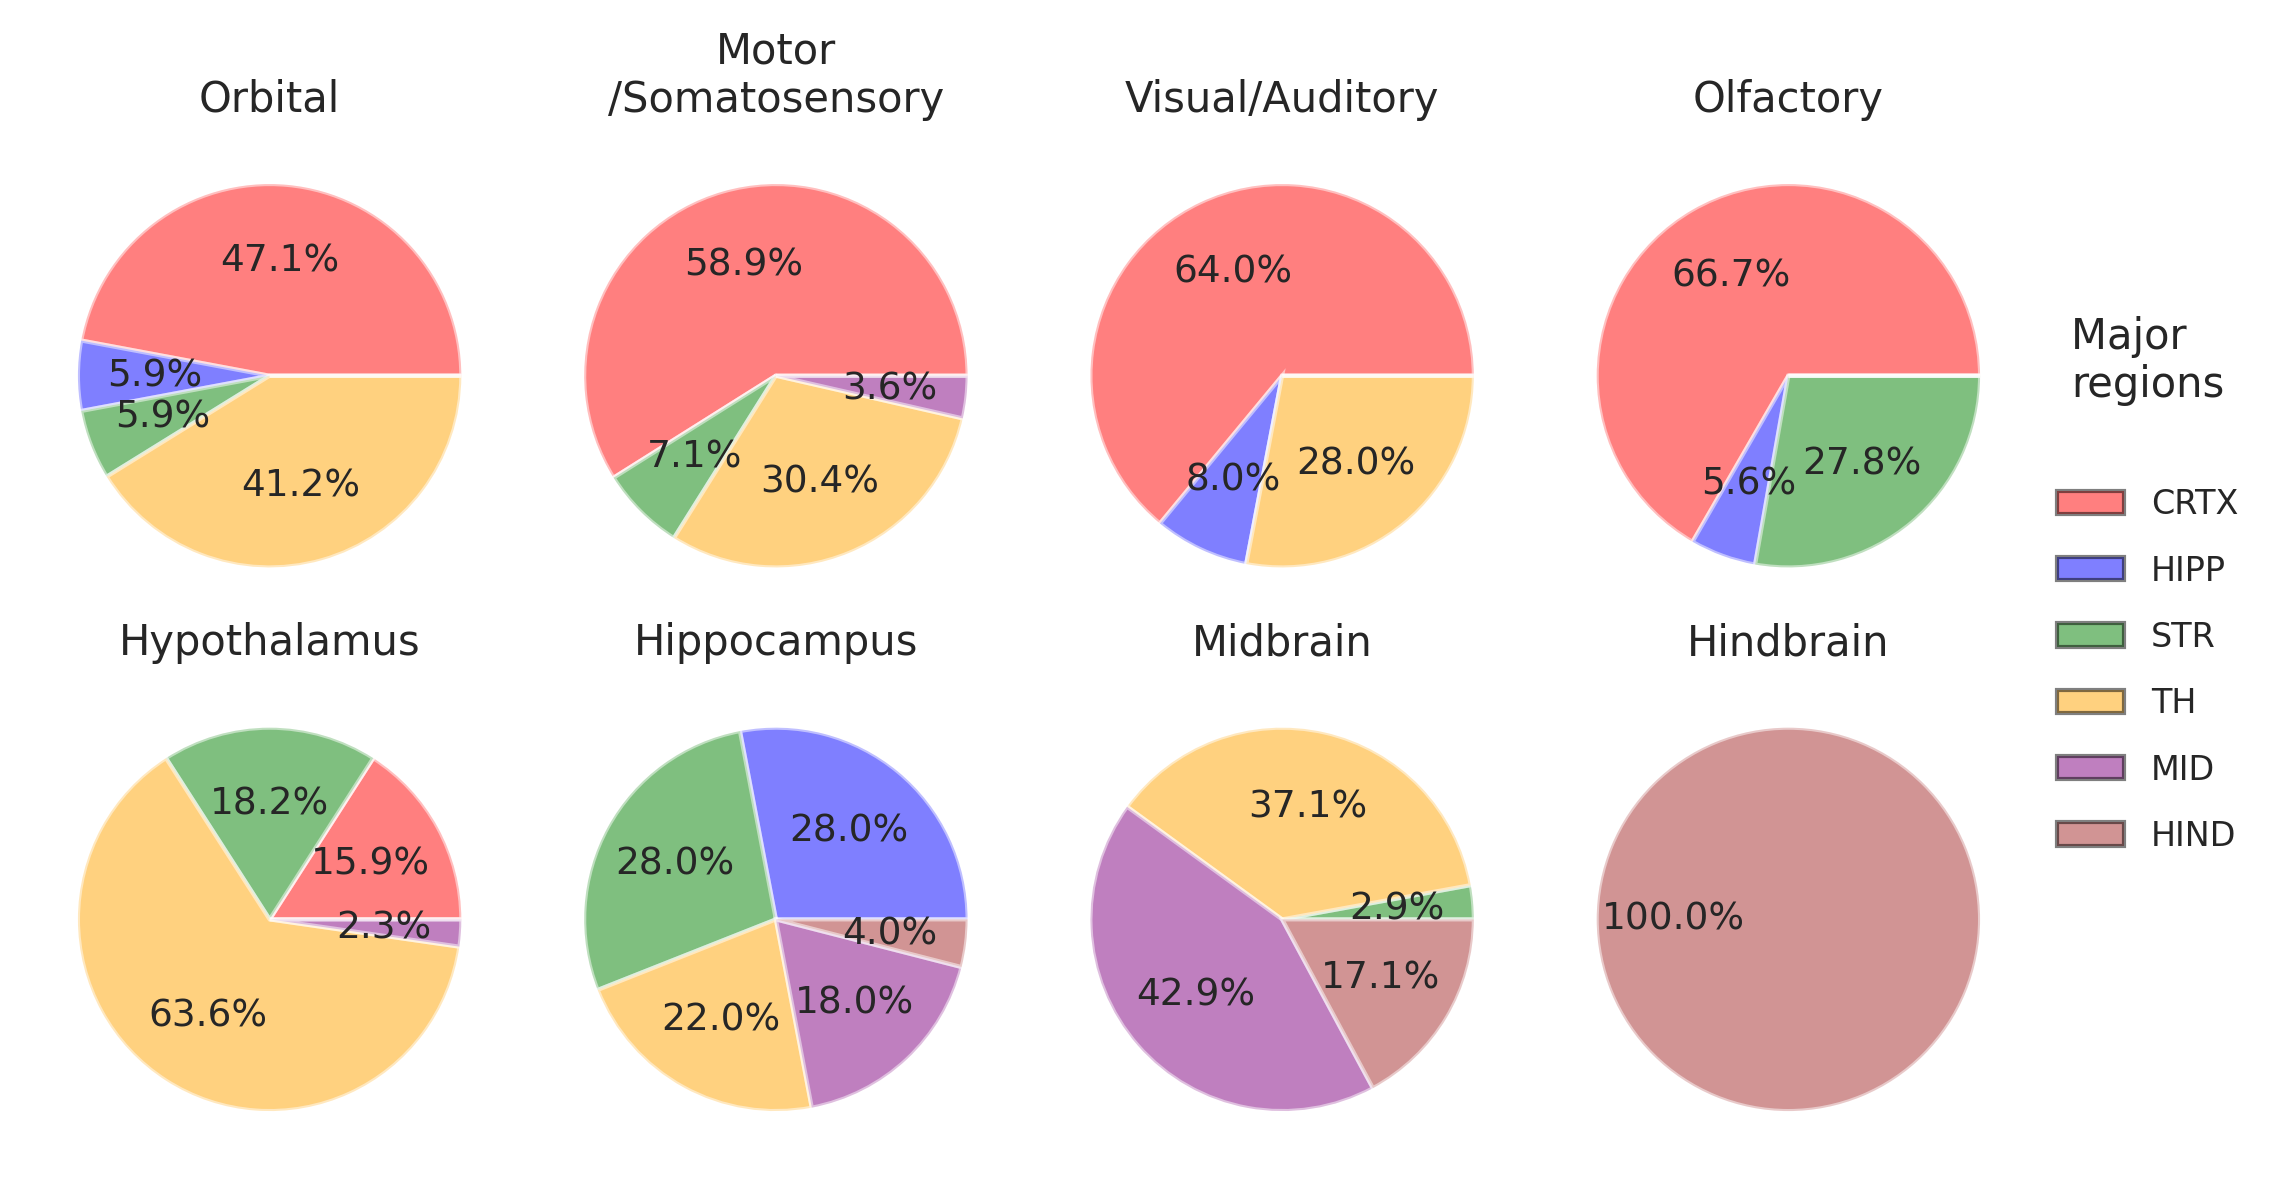

In [212]:
# Create the 4x2 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(6.84, 4), dpi=300)

# Iterate over each subplot and plot a pie chart
for i, ax in enumerate(axes.flat):
    
    data = []
    data.append(region_distribution_per_community[reordered_community_ids[i]]['CRTX'])
    data.append(region_distribution_per_community[reordered_community_ids[i]]['HIPP'])
    data.append(region_distribution_per_community[reordered_community_ids[i]]['STR'])
    data.append(region_distribution_per_community[reordered_community_ids[i]]['TH'])
    data.append(region_distribution_per_community[reordered_community_ids[i]]['MID'])
    data.append(region_distribution_per_community[reordered_community_ids[i]]['HIND'])
    
    # print(data)
    #labels=mb_atlas.COARSER_WB_ANATOMICAL_AREAS,
    
    # index_of_community_id = reordered_community_ids.index(i)
    
    # Plot the pie chart
    ax.pie(data, colors=mb_atlas.COARSER_WB_ANATOMICAL_AREAS_COLOR, 
           autopct=lambda p: f'{p:.1f}%' if p > 0 else '', 
           textprops={'fontsize': 2*TEXT_FONT_SIZE-3},
           wedgeprops={"alpha": 0.5})
    ax.set_aspect('equal')  # Ensure pie is drawn as a circle
    ax.set_title(f'{community_labels[i]}', fontsize=2*TEXT_FONT_SIZE-2)  # Set subplot title
    
# Adjust spacing between subplots
plt.tight_layout()

# Create custom legend handles with labels and colors
legend_patches = [mpatches.Patch(color=mb_atlas.COARSER_WB_ANATOMICAL_AREAS_COLOR[c], 
                                 label=mb_atlas.COARSER_WB_ANATOMICAL_AREAS[c]) for c in range(mb_atlas.COARSER_WB_ANATOMICAL_AREAS_COUNT)]
legend = plt.legend(handles=legend_patches, frameon=False, loc="center", 
           bbox_to_anchor=(1.25, 1.2), ncol=1, 
                    fontsize=2*TEXT_FONT_SIZE-4, 
                    labelspacing=1)

legend.set_title("Major \nregions\n", prop={'size': 2*TEXT_FONT_SIZE-2})
# Set alpha for legend markers
for handle in legend.legendHandles:
    handle.set_alpha(0.5)
# Set border color around legend labels
for patch in legend.get_patches():
    patch.set_edgecolor('black')

# Display the figure
plt.show()